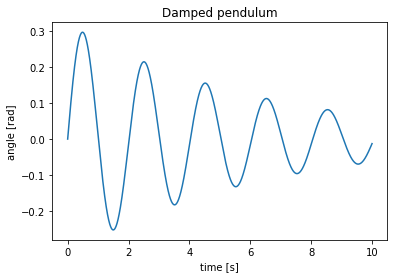

In [8]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle, seed

from echo_state_network import ESN

gamma = 3
damping = 0
K = 12
omega = 4
g = 9.81

def pendulum(u, t):
    #Should return y', y''
    # angle'' = -g/l * sin(angle) - damping * radius / mass * angle'
    
    return (u[1], -9.81 * np.sin(u[0]) - 4 * 0.8 / 10 * u[1])

t = np.linspace(0, 10, 10000)
solution = odeint(pendulum, [0, 1], t)
angle = solution[:,0]

plt.plot(t, angle)
plt.title('Damped pendulum')
plt.xlabel('time [s]')
plt.ylabel('angle [rad]')

indices = list(range(len(t)))
cutoff = int(len(solution) * 0.8)

# seed(6)
# shuffle(indices)

training_indices = indices[0:cutoff]
validation_indices = indices[cutoff:]

training_input = t[sorted(training_indices)]
training_output = angle[sorted(training_indices)]

validation_input = t[sorted(validation_indices)]
validation_output = angle[sorted(validation_indices)]

harvesting states...
fitting...
training error:
0.0005349528754296496


Text(0.5, 1.0, 'Prediction on all validation set at once')

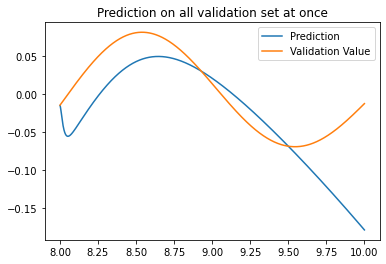

In [113]:
esn = ESN(
    1, 
    1, 
    n_reservoir=1000, 
    spectral_radius=0.8, 
    sparsity=0.1, # number of nodes connected / max number of links 
    noise=0, 
    input_shift=None,
    input_scaling=None, 
    teacher_forcing=True, 
    feedback_scaling=None,
    teacher_scaling=None, 
    teacher_shift=None,
    out_activation=lambda x: x, #tanh, sigmoid
    inverse_out_activation=lambda x: x, #TODO ?
    random_state=None, 
    silent=False
)

esn.fit(training_input, training_output)

prediction = esn.predict(validation_input)[:,0]

plt.plot(validation_input, prediction, validation_input, validation_output)
plt.legend(['Prediction', 'Validation Value'])
plt.title('Prediction on all validation set at once')

#TODO accuracy on number of steps (average)
#TODO ARIMA - try prediction
#TODO LSTM

Text(0, 0.5, 'Error')

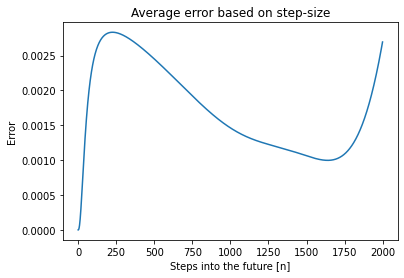

In [121]:
def compute_R(predicted_angle, known_angle):
    SS_res = ((predicted_angle - known_angle) ** 2).sum()
    avg = known_angle.mean()
    SS_tot = ((known_angle - avg) ** 2).sum()
    
    if (SS_tot == 0):
        print('Not good')
        
    return 1 - SS_res / SS_tot

# print('R^2 value on the whole dataset:', compute_R(prediction, validation_output))

steps = []
average_error = []

for index in range(1, len(validation_input)):
    steps.append(index)
    
    prediction = esn.predict(validation_input[0:index])[:,0]
    
    err = ((prediction - validation_output[0:index]) ** 2).mean()    
    average_error.append(err)


plt.plot(steps, average_error)
plt.title('Average error based on step-size')
plt.xlabel('Steps into the future [n]')
plt.ylabel('Error')